This notebook has been made to determine a rough estimate of the receiver temperature and its error bars. This has been done by using the process described in Adam Beardsley's [memo](http://reionization.org/wp-content/uploads/2017/04/HERA19_Tsys_3April2017.pdf), which fit auto-correlation data to a simulated global sky model using the relationship.

In [2]:
import numpy as np
from scipy.optimize import curve_fit
from scipy import interpolate
import matplotlib.pyplot as plt
import aipy
from astropy.io import fits
import linsolve
import os
import glob

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [29]:
JD = 2458116

# Tsky_file = '/data4/tcox/HERA_IDR1_analysis/HERA_Tsky.npz'
Tsky_file = '/Users/tyler/Desktop/Research/Tsys/data/HERA_tsky_fast.npz'
data = np.load(Tsky_file)
freqs = data['freqs']  # These are already made to fit the data
model_lsts = data['lsts']
model_HERA_Tsky = data['HERA_Tsky']

data = np.load('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/2458098/fits.npz'.format(JD))
nrao_feeds = data['nrao_feeds']
HERA_list = data['HERA_list']
freqs = data['freqs']

# Load in data from previous script
autos_file = '/Users/tyler/Desktop/Research/Tsys/data/IDR2_{}_autos_512_chan.npz'.format(JD)
data = np.load(autos_file)
data_lsts = data['lsts']
data_ave = data['data_ave']

In [30]:
# Generate variance matrix for measurements
dB = 100.0 / data_ave.shape[3] # Bandwidth in MHz
t = 10.8 # seconds

C = data_ave / np.sqrt(1e6*dB*t)

pols = ['X', 'Y']
npol = len(pols)
nant = len(HERA_list)

new_feeds = list(set(HERA_list)-set(nrao_feeds))

# Fit auto data to model
auto_fits = np.zeros((npol, nant, len(freqs), 2))  # gain_amp, gain_slope, rxr_amp
covs = np.zeros((npol, nant, len(freqs), 2, 2))

# Create interp_func to return Tsky - <Tsky> (ie, deviation from mean)
interp_Tsky = interpolate.interp1d(model_lsts, model_HERA_Tsky, kind='cubic', axis=2, fill_value='extrapolate')
interp_Tsky_array = interp_Tsky(data_lsts[0])
Tsky_mean = np.mean(interp_Tsky_array, axis=2)
Tsky_prime = interp_Tsky_array - np.expand_dims(Tsky_mean, 2)

In [31]:
def gain_rxr_temp(auto_fits, covs, save_npz=True):
    '''
    auto_fits[:, :, :, 0] -> A_0
    auto_fits[:, :, :, 1] -> R_0
    '''
    gains = auto_fits[:, :, :, 0]
    rxr_temp = auto_fits[:, :, :, 1] / gains - Tsky_mean[:, None, :]  
    rxr_temp_err = np.sqrt(covs[:,:,:,0,0] * auto_fits[:, :, :, 1]**2 / auto_fits[:, :, :, 0]**4  + 
                           covs[:,:,:,1,1] * 1.0 / auto_fits[:, :, :, 0]**2 - 
                           2 * covs[:,:,:,0,1] * auto_fits[:, :, :, 1] / auto_fits[:, :, :, 0]**3)
    if save_npz:
        np.savez('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{}/rxr_temp_w_err.npz'.format(JD), gains=gains, 
                                                                rxr_temp_err=rxr_temp_err, 
                                                                rxr_temp=rxr_temp,
                                                                auto_fits=auto_fits,
                                                                covs=covs)
    return gains, rxr_temp, rxr_temp_err

In [32]:
data_lsts.size

8708

In [33]:
sim = True

cov_mat = np.zeros((npol, nant, len(freqs), 2, 2))

if os.path.exists('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{}/rxr_temp_w_err.npz'.format(JD)) and not sim:
    fits_data = np.load('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{}/rxr_temp_w_err.npz'.format(JD))
    gains = fits_data['gains']
    rxr_temp_err = fits_data['rxr_temp_err']
    rxr_temp = fits_data['rxr_temp']
    covs = fits_data['covs']
    auto_fits = fits_data['auto_fits']

    
else:
    for pol in xrange(npol):
        for anti, ant in enumerate(HERA_list):
            d_ls = {}
            w_ls = {}
            kwargs = {}
            for i in range(data_lsts.shape[1]):
                d_ls['Tsky%d*g+n' % i] = data_ave[pol, ant, i, :]
                kwargs['Tsky%d' % i] = Tsky_prime[pol, :, i]
            ls = linsolve.LinearSolver(d_ls, w_ls, **kwargs)
            sol = ls.solve()
            auto_fits[pol,anti,:,0] = sol['g']
            auto_fits[pol,anti,:,1] = sol['n']
    
for fi in np.arange(len(freqs)):
    interp_values = Tsky_prime[pol, fi, :]
    A = np.column_stack([Tsky_prime[pol, fi, :], np.ones_like(Tsky_prime[pol,fi,:])])
    ATA = np.linalg.inv(np.dot(A.T, A))
    for pol in xrange(npol):
        for anti, ant in enumerate(HERA_list):
            cov_mat[pol, anti, fi, :, :] = ATA

ValueError: could not broadcast input array from shape (256) into shape (64)

In [15]:
gains, rxr_temp, rxr_temp_err = gain_rxr_temp(auto_fits, cov_mat, save_npz=False)

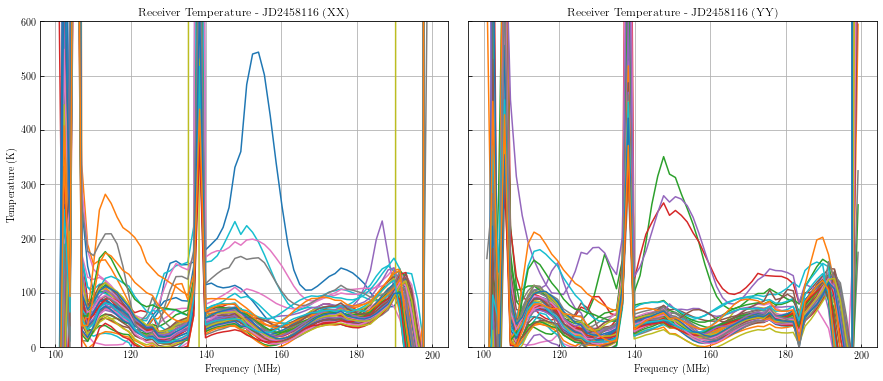

In [17]:
fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 6))

for poli, pol in enumerate(pols):
    for anti, ant in enumerate(HERA_list):
        axarr[poli].plot(freqs, rxr_temp[poli, anti, :], label=str(ant))
    axarr[poli].set_ylim([0,600])
    axarr[0].set_ylabel('Temperature (K)')
    axarr[0].set_xlabel('Frequency (MHz)')
    axarr[1].set_xlabel('Frequency (MHz)')
    axarr[poli].set_title('Receiver Temperature - JD{JD} ({pol})'.format(JD=JD,pol=2*pol))
    axarr[poli].grid()
    
plt.subplots_adjust(wspace=0.05)
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/receiver_temp_{JD}.png'.format(JD=JD), bbox_inches='tight')

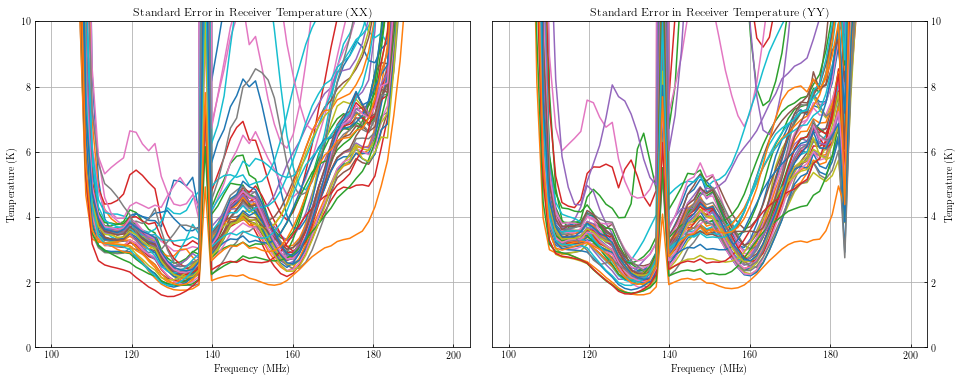

In [18]:
fig, axarr = plt.subplots(1, 2,figsize=(16, 6))

for poli, pol in enumerate(pols):
    for anti, ant in enumerate(HERA_list):
        axarr[poli].plot(freqs, rxr_temp_err[poli, anti, :], label=str(ant))
    axarr[poli].set_xlabel('Frequency (MHz)')
    axarr[poli].set_ylim([0,10])
    axarr[poli].set_ylabel('Temperature (K)')
    axarr[1].yaxis.tick_right()
    axarr[1].yaxis.set_label_position("right")
    axarr[poli].set_ylabel('Temperature (K)')
    axarr[poli].set_title('Standard Error in Receiver Temperature ({})'.format(2*pol))
    #plt.show()
axarr[0].grid()
axarr[1].grid()
plt.subplots_adjust(wspace=0.05)
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/rxr_standard_err_{pol}_{JD}.png'.format(pol=2*pol, JD=JD), bbox_inches='tight')

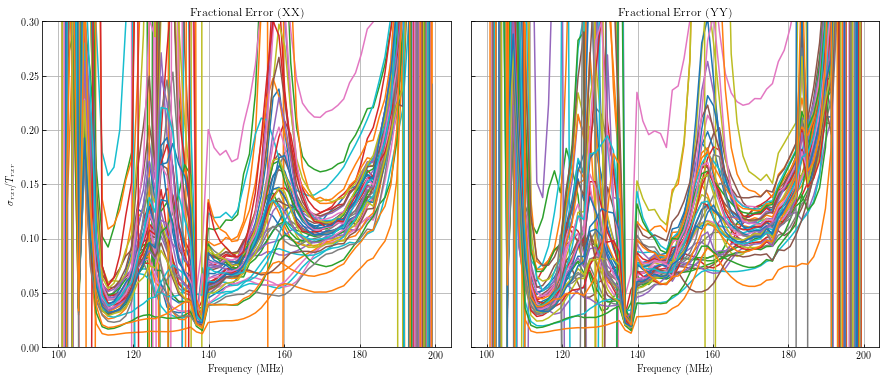

In [19]:
fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 6))

for poli, pol in enumerate(pols):
    for anti, ant in enumerate(HERA_list):
        '''
        if ant in bad_ants[poli]:
            axarr[poli].plot(freqs, rxr_temp_err[poli, anti, :] / rxr_temp[poli, anti, :], label=str(ant), linestyle='--')
        elif ant in [98,66,141]:
            axarr[poli].plot(freqs, rxr_temp_err[poli, anti, :] / rxr_temp[poli, anti, :], label=str(ant))
        '''
        axarr[poli].plot(freqs, rxr_temp_err[poli, anti, :] / rxr_temp[poli, anti, :], label=str(ant))
    axarr[poli].set_title('Fractional Error ({})'.format(2*pol))
    axarr[0].set_ylabel(r'$\sigma_{rxr} / T_{rxr}$')
    axarr[poli].set_xlabel('Frequency (MHz)')
    axarr[poli].set_ylim([0,0.3])
    #axarr[poli].legend()
    axarr[poli].grid()
plt.subplots_adjust(wspace=0.05)
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/rxr_fraction_err_{JD}.png'.format(JD=jd), bbox_inches='tight')


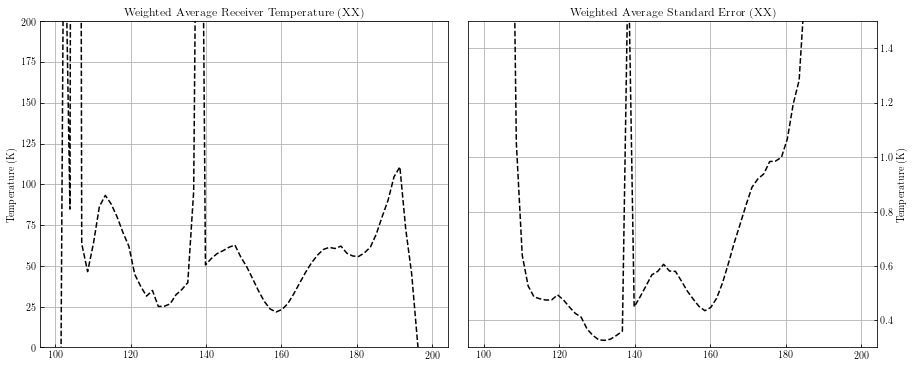

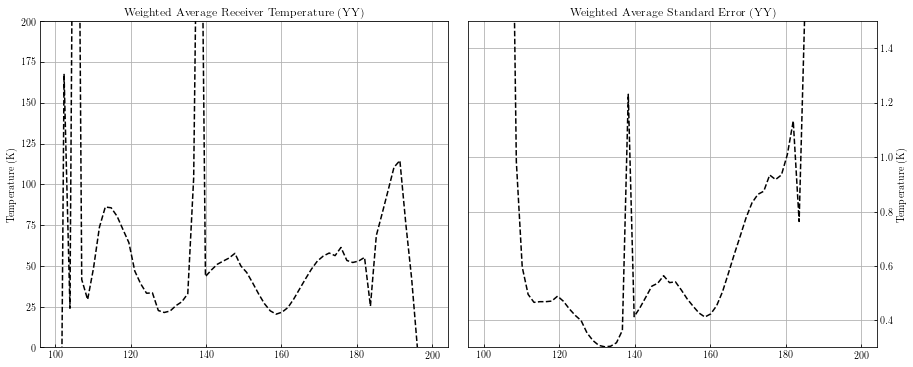

In [20]:
avg_temps = np.zeros((2, rxr_temp.shape[2]))
avg_err = np.zeros((2, rxr_temp.shape[2]))

for poli, pol in enumerate(pols):
    fig, axarr = plt.subplots(1, 2, figsize=(15, 6))
    for i in np.arange(rxr_temp.shape[2]):
        #idx_min = np.where(rxr_temp[1, :, i] > 0)[0]
        #idx = np.where(rxr_temp[1, :, i] < 1e5)[0]
        #idx = np.intersect1d(idx_min, idx_max)
        avg_temps[poli,i] = np.average(rxr_temp[poli,:,i], weights=1.0/rxr_temp_err[poli,:,i]**2)
        avg_err[poli,i] = np.sqrt(1.0 / np.sum(1.0 / rxr_temp_err[poli,:,i]**2))

    axarr[0].plot(freqs, avg_temps[poli,:], 'k--')  
    axarr[0].set_title('Weighted Average Receiver Temperature ({})'.format(2*pol))
    axarr[0].set_ylim([0,200])
    axarr[0].set_ylabel('Temperature (K)')
    axarr[1].set_ylabel('Temperature (K)')
    axarr[1].plot(freqs, avg_err[poli,:], 'k--') 
    axarr[1].set_title('Weighted Average Standard Error ({})'.format(2*pol))
    axarr[1].yaxis.tick_right()
    axarr[1].yaxis.set_label_position("right")
    axarr[1].set_ylim([0.3,1.5])
    axarr[0].grid()
    axarr[1].grid()
    plt.subplots_adjust(wspace=0.05)
    plt.show()

#np.savez('average_temp_{pol}_{JD}'.format(pol=pols[0], JD=JD), avg_temps=avg_temps, avg_err=avg_err)

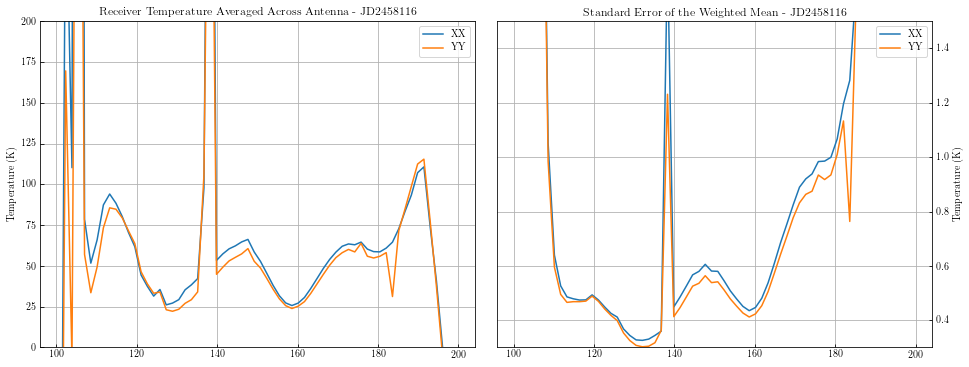

In [22]:
avg_temps = np.zeros((2, rxr_temp.shape[2]))
avg_err = np.zeros((2, rxr_temp.shape[2]))

fig, axarr = plt.subplots(1, 2, figsize=(16, 6))

for poli, pol in enumerate(pols):
    for i in np.arange(rxr_temp.shape[2]):
        avg_temps[poli,i] = np.average(rxr_temp[poli,:,i], weights=1.0/rxr_temp_err[poli,:,i])
        avg_err[poli,i] = np.sqrt(1.0 / np.sum(rxr_temp_err[poli,:,i]**(-2)) )
        
    axarr[0].plot(freqs, avg_temps[poli,:], label=str(2*pol))      
    axarr[0].set_title('Receiver Temperature Averaged Across Antenna - JD{}'.format(JD))
    axarr[0].set_ylim([0,200])
    axarr[0].set_ylabel('Temperature (K)')
    axarr[1].set_ylabel('Temperature (K)')
    axarr[1].plot(freqs, avg_err[poli,:], label=str(2*pol)) 
    axarr[1].set_title('Standard Error of the Weighted Mean - JD{}'.format(JD))
    axarr[1].yaxis.tick_right()
    axarr[1].yaxis.set_label_position("right")
    axarr[1].set_ylim([0.3,1.5])
    axarr[0].legend()
    axarr[1].legend()
    axarr[poli].grid()

plt.subplots_adjust(wspace=0.05)
#plt.show()
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/avg_temp_w_err_{JD}.png'.format(JD=jd), bbox_inches='tight')

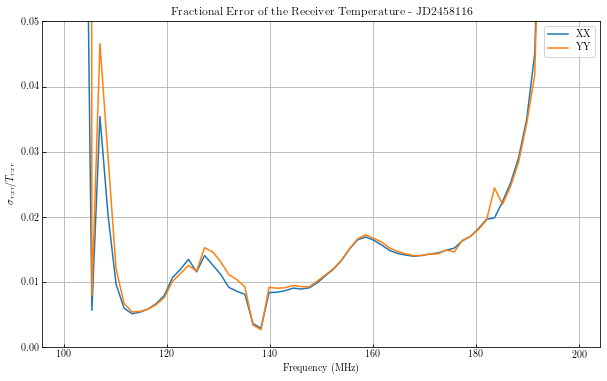

In [24]:
plt.figure(figsize=(10,6))
plt.plot(freqs, avg_err[0,:] / np.abs(avg_temps[0,:]), label='XX')
plt.plot(freqs, avg_err[1,:] / np.abs(avg_temps[1,:]), label='YY')
plt.ylim([0,0.05])
plt.title('Fractional Error of the Receiver Temperature - JD{}'.format(JD))
plt.xlabel('Frequency (MHz)')
plt.ylabel(r'$\sigma_{rxr} / T_{rxr}$')
plt.legend()
plt.grid()
#plt.show()
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/avg_fractional_err_{JD}.png'.format(JD=jd), bbox_inches='tight')

# Time Dependence on the Error Bars

In [25]:
JD = 2458098

data = np.load('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/2458098/fits.npz'.format(JD))
nrao_feeds = data['nrao_feeds']
HERA_list = data['HERA_list']
freqs = data['freqs']

# Load in data from previous script
autos_file = '/Users/tyler/Desktop/Research/Tsys/data/IDR2_{}_autos.npz'.format(JD)
data = np.load(autos_file)
data_lsts = data['lsts']
data_ave = data['data_ave']


In [26]:
# Generate variance matrix for measurements
dB = 100.0 / data_ave.shape[3] # Bandwidth in MHz
t = 10.8 # seconds

C = data_ave / np.sqrt(1e6*dB*t)

pols = ['X', 'Y']
npol = len(pols)
nant = len(HERA_list)

new_feeds = list(set(HERA_list)-set(nrao_feeds))

# Fit auto data to model
auto_fits = np.zeros((npol, nant, len(freqs), 2))  # gain_amp, gain_slope, rxr_amp
covs = np.zeros((npol, nant, len(freqs), 2, 2))

# Create interp_func to return Tsky - <Tsky> (ie, deviation from mean)
interp_Tsky = interpolate.interp1d(model_lsts, model_HERA_Tsky, kind='cubic', axis=2, fill_value='extrapolate')
interp_Tsky_array = interp_Tsky(data_lsts[0])
Tsky_mean = np.mean(interp_Tsky_array, axis=2)
Tsky_prime = interp_Tsky_array - np.expand_dims(Tsky_mean, 2)

In [27]:
sim = True

data_frac = [0.1, 0.25, 0.5, 0.75, 0.9]

selected_ant = 53
ant_idx = np.where(HERA_list == selected_ant)[0]

rxr_temp_var_frac = []
rxr_temp_err_frac = []

auto_fits = np.zeros((npol,len(freqs), 2))
covs = np.zeros((npol, len(freqs), 2, 2))

np.random.seed()

for di, frac in enumerate(data_frac):
    idx = np.random.choice(np.arange(data['data_ave'].shape[2]), size=int(data['data_ave'].shape[2]*frac), replace=False)
    data_ave = data['data_ave'][:,:,idx,:]
    data_lsts = data['lsts'][:,idx]
    interp_Tsky = interpolate.interp1d(model_lsts, model_HERA_Tsky, kind='cubic', axis=2, fill_value='extrapolate')
    interp_Tsky_array = interp_Tsky(data_lsts[0])
    Tsky_mean = np.mean(interp_Tsky_array, axis=2)
    Tsky_prime = interp_Tsky_array - np.expand_dims(Tsky_mean, 2)
    for pol in xrange(npol):
        for fi, freq in enumerate(freqs):
            interp_values = Tsky_prime[pol, fi, :]
            out = curve_fit(curve_to_fit, data_lsts[pol], data_ave[pol][selected_ant, :, fi],
                            bounds=(0, np.inf), absolute_sigma=True)
            auto_fits[pol, fi, :] = out[0]
            covs[pol, fi, :, :] = out[1]
    rxr_temp = auto_fits[:,:,1] / auto_fits[:,:, 0] - Tsky_mean[:, :]
    rxr_temp_err = np.sqrt(covs[:,:,0,0] * auto_fits[:, :, 1]**2 / auto_fits[:, :, 0]**4  + 
                           covs[:,:,1,1] * 1.0 / auto_fits[:, :, 0]**2 - 
                           2 * covs[:,:,0,1] * auto_fits[:, :, 1] / auto_fits[:, :, 0]**3)
    rxr_temp_var_frac.append(rxr_temp)
    rxr_temp_err_frac.append(rxr_temp_err)

NameError: name 'rxr_temp_new' is not defined

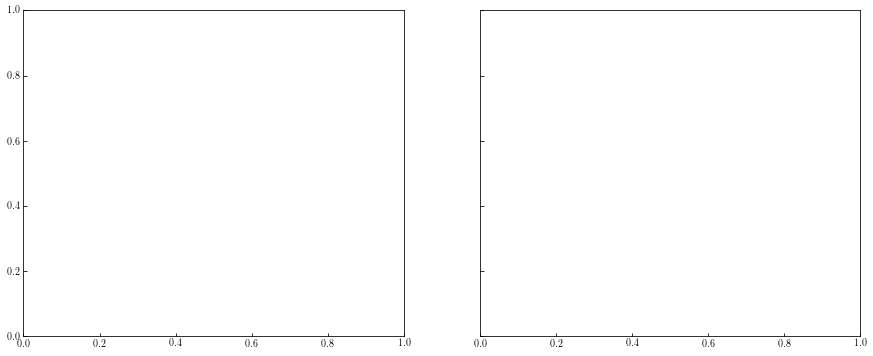

In [28]:
fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 6))

for poli, pol in enumerate(pols):
    axarr[poli].plot(freqs, rxr_temp_new[poli, ant_idx][0], label=str(selected_ant))
    for i in np.arange(len(rxr_temp_var_frac)):
        axarr[poli].plot(freqs, np.abs(rxr_temp_var_frac[i][poli]),
                         label='Ant {ant}: {frac}\% Data Used'.format(ant=selected_ant,frac=data_frac[i]*100))
    axarr[poli].set_ylim([0,150])
    axarr[poli].set_ylabel('Temperature (K)')
    axarr[poli].set_xlabel('Frequency (MHz)')
    axarr[poli].set_title('Receiver Temperature - JD{JD} ({pol})'.format(JD=jd,pol=2*pol))
    axarr[1].yaxis.tick_right()
    axarr[1].yaxis.set_label_position("right")
    axarr[poli].grid()
    axarr[poli].legend()
plt.subplots_adjust(wspace=0.05)
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/receiver_temp_{JD}.png'.format(JD=JD), bbox_inches='tight')

In [ ]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 6))

for poli, pol in enumerate(pols):
    for i in np.arange(len(rxr_temp_var_frac)):
        axarr[poli].plot(freqs, rxr_temp_err_frac[i][poli],
                      label='Ant {ant}: {frac}\% Data Used'.format(ant=selected_ant,frac=data_frac[i]*100))
    axarr[poli].plot(freqs, rxr_temp_err_new[poli, ant_idx][0], label='Ant: {ant}'.format(ant=selected_ant))
    axarr[poli].set_xlabel('Frequency (MHz)')
    axarr[poli].set_ylim([0,20])
    axarr[poli].set_ylabel('Temperature (K)')
    axarr[1].yaxis.tick_right()
    axarr[1].yaxis.set_label_position("right")
    axarr[0].set_ylabel('Temperature (K)')
    axarr[poli].set_title('Standard Error in Receiver Temperature ({})'.format(2*pol))
    axarr[poli].grid()
    axarr[poli].legend()
plt.subplots_adjust(wspace=0.05)
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/rxr_standard_err_{pol}_{JD}.png'.format(pol=2*pol, JD=JD), bbox_inches='tight')

In [ ]:
fig, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 6))

for poli, pol in enumerate(pols):
    for i in np.arange(len(rxr_temp_var_frac)):
        axarr[poli].plot(freqs, rxr_temp_err_frac[i][poli] / rxr_temp_var_frac[i][poli],
                         label='Ant {ant}: {frac}\% Data Used'.format(ant=selected_ant,frac=data_frac[i]*100))
    axarr[poli].plot(freqs, rxr_temp_err_new[poli, ant_idx][0] / rxr_temp_new[poli, ant_idx][0], label='Ant: {ant}'.format(ant=selected_ant))
    axarr[poli].set_title('Fractional Error ({})'.format(2*pol))
    axarr[0].set_ylabel(r'$\sigma_{rxr} / T_{rxr}$')
    axarr[poli].set_xlabel('Frequency (MHz)')
    axarr[poli].set_ylim([0,0.5])
    axarr[poli].grid()
    axarr[poli].legend()
plt.subplots_adjust(wspace=0.05)
#plt.savefig('/Users/tyler/Desktop/Research/Tsys/Tsys_plots/IDR2/{JD}/rxr_fraction_err_{JD}.png'.format(JD=jd), bbox_inches='tight')

# General Trends Across Days

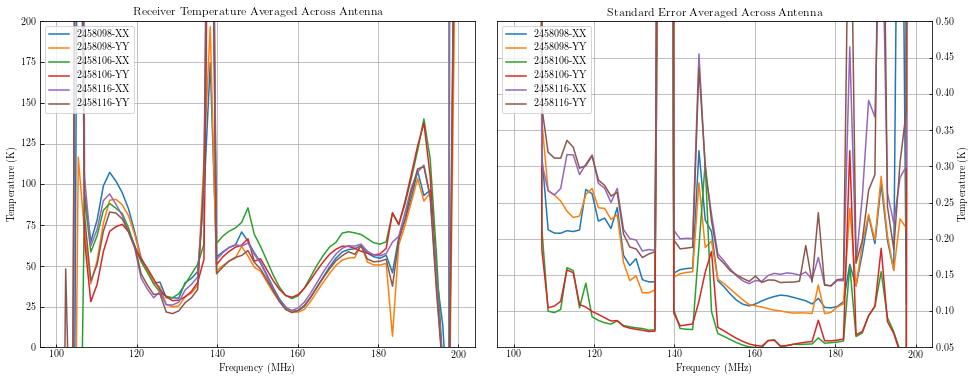

In [132]:
files = glob.glob('/Users/tyler/Desktop/Research/Tsys/data/average_*')
files.sort()
fig, axarr = plt.subplots(1, 2, figsize=(16, 6))
jds = ['2458098','2458098 Wide Beam', '2458106', '2458106 Wide Beam','2458116', '2458116 Wide Beam']
new_beam_jds = ['2458098 Wide Beam', '2458106 Wide Beam', '2458116 Wide Beam']
old_beam_jds = ['2458098', '2458106', '2458116']


for j, f in enumerate(files[::2]):
    temps = np.load(f)['avg_temps']
    errs = np.load(f)['avg_err']
    for i in np.arange(2):
        axarr[0].plot(freqs, temps[i], label=old_beam_jds[j] + '-' + 2*pols[i])
        axarr[1].plot(freqs, errs[i], label=old_beam_jds[j] + '-' + 2*pols[i])
    axarr[0].set_title('Receiver Temperature Averaged Across Antenna')
    axarr[0].set_ylim([0,200])
    axarr[0].set_ylabel('Temperature (K)')
    axarr[1].set_ylabel('Temperature (K)')
    axarr[0].set_xlabel('Frequency (MHz)')
    axarr[1].set_xlabel('Frequency (MHz)')
    axarr[1].set_title('Standard Error Averaged Across Antenna')
    axarr[1].yaxis.tick_right()
    axarr[1].yaxis.set_label_position("right")
    axarr[1].set_ylim([0.05,0.5])
    axarr[0].legend()
    axarr[1].legend()
    axarr[0].grid()
    axarr[1].grid()
plt.subplots_adjust(wspace=0.05)
#plt.savefig('averaged_receiver_temp.png', bbox_inches='tight')

Text(0.5,1,u'Fractional Errors in Receiver Temperature')

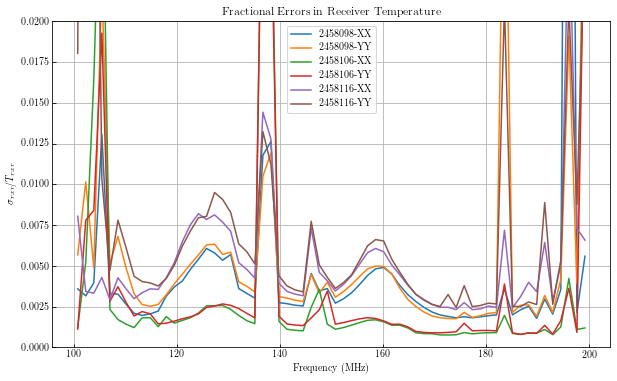

In [68]:
plt.figure(figsize=(10,6))

for j, f in enumerate(files[::2]):
    temps = np.load(f)['avg_temps']
    errs = np.load(f)['avg_err']
    for i in np.arange(2):
        plt.plot(freqs, np.abs(errs[i]/temps[i]) , label=old_beam_jds[j] + '-' + 2*pols[i])

plt.grid()
plt.legend()
plt.ylim([0,0.02])
plt.xlabel('Frequency (MHz)')
plt.ylabel(r'$\sigma_{rxr} / T_{rxr}$')
plt.title('Fractional Errors in Receiver Temperature')
#plt.savefig('fractional_errors.png', bbox_inches='tight')